In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from p2mpp.data.shapenet import ShapeNet

In [3]:
dataset = ShapeNet(
    file_list=r"C:\ORamaVR\Python\Pixel2MeshPlusPlusTorch\data\train_list.txt",
    data_root=r"C:\ORamaVR\Datasets\p2mppdata\p2mppdata\train",
    image_root=r"C:\ORamaVR\Datasets\ShapeNetRendering",
)

In [4]:
imgs, imgs_orig, points, normals, poses, filename = dataset[0].values()

In [5]:
from p2mpp.data.datamodule import DataModule

In [6]:
datamodule = DataModule(train_file_list=r"C:\ORamaVR\Python\Pixel2MeshPlusPlusTorch\data\train_list.txt",
                        test_file_list=r"C:\ORamaVR\Python\Pixel2MeshPlusPlusTorch\data\test_list.txt",
                        data_root=r"C:\ORamaVR\Datasets\p2mppdata\p2mppdata",
                        image_root=r"C:\ORamaVR\Datasets\ShapeNetRendering",
                        batch_size=8,
                        num_workers=1,
                        )


In [7]:
for batch in datamodule.train_dataloader():
    break

In [8]:
from p2mpp.models.p2m import P2MModel, BaseMeshConfig

In [9]:
basemeshconfig = BaseMeshConfig("ellipsoid", mesh_pose=(0.0, 0.0, 0.0))

In [10]:
model = P2MModel(
    hidden_dim=192,
    last_hidden_dim=192,
    coord_dim=3,
    backbone="vgg16",
    gconv_activation=True,
    z_threshold=0,
    align_with_tensorflow=True,
    camera_c=(111.5, 111.5),
    camera_f=(248.0, 248.0),
    base_mesh_config=basemeshconfig
)

c:\oramavr\python\pixel2meshplusplustorch\p2mpp\models\mesh\ellipsoid.py:21: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:607.)
  return torch.sparse.FloatTensor(i, v, shape)


In [11]:
images = batch["images"]
poses = batch["poses"]

In [15]:
model = model.cuda()
images = images.cuda()
poses = poses.cuda()

In [16]:
output = model(images, poses)

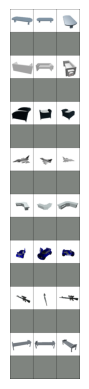

In [60]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# get the reconst tensor from the output dictionary
input_tensor = batch["images"].cpu()
reconst_tensor = output["reconst"].cpu()

t = torch.cat([input_tensor, reconst_tensor], dim=1)
batch_size, n_views, channel, height, width = t.shape
t = t.reshape(batch_size * n_views, channel, height, width)

# create a grid of images
grid_img = vutils.make_grid(t, nrow=3, normalize=True)

# display the grid
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()


In [61]:
grid_img.shape

torch.Size([3, 3618, 680])

In [58]:
torch.cat([batch["images"], reconst_tensor], dim=1).shape

torch.Size([8, 6, 3, 224, 224])

In [21]:
from p2mpp.utils.vis.renderer import MeshRenderer
renderer = MeshRenderer(camera_f=(248., 248.), camera_c=(111.5, 1115.), mesh_pos=(0., 0., 0.))

c:\Users\Farid\anaconda3\envs\p2mpptorch\lib\site-packages\neural_renderer_pytorch-1.1.3-py3.9-win-amd64.egg\neural_renderer\renderer.py:41: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:85.)
  self.dist_coeffs = torch.cuda.FloatTensor([[0., 0., 0., 0., 0.]])


In [22]:
from p2mpp.models.mesh.ellipsoid import Ellipsoid
ellipsoid = Ellipsoid(mesh_pos=(0., 0., 0.))

In [23]:
from p2mpp.models.losses.p2m import P2MLoss
from p2mpp.configs import LossConfig
p2mloss = P2MLoss(loss_config=LossConfig(), ellipsoid=ellipsoid)

In [34]:
batch_cuda = {"images": batch["images"].cuda(), "poses": batch["poses"].cuda(), "points": batch["points"].cuda(), "normals": batch["normals"].cuda(), "filename": batch["filename"], "points_orig": batch["points_orig"], "normals_orig": batch["normals_orig"]}

In [36]:
p2mloss = p2mloss.cuda()

In [37]:
loss, loss_summary = p2mloss(output, batch_cuda)

In [48]:
render_mesh = renderer.p2m_batch_visualize(batch, output, ellipsoid.faces)

In [50]:
render_mesh.shape

torch.Size([3, 2688, 896])

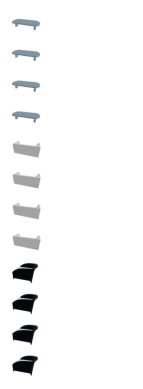

In [53]:
import matplotlib.pyplot as plt

plt.imshow(render_mesh.permute(1, 2, 0))
plt.axis('off')
plt.show()
